# Latent Manipulation

In **cloudy** the volumes are encoded in a low dimensional latent space, $128\times 128\times 32$. The diffusion works in a latent space normalized using statistics from the training dataset. The normalized latents also works with channels first layout.

In this example, we implemented a cloud interpolation by means of interpolating the diffused latents and guiding towards the interpolated latent. Instead of sampling a volume, we sample directly the latent and guide the diffusion towards the desired latent representation.


In [1]:
try:  # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Let's initialize as usual, only difference we will load two latents this time.

In [2]:
import cloudy
import numpy as np
import torch


pipeline = cloudy.create_pipeline('./test')
# pipeline.download_pretrained()


def load_test_latent_and_grid(id):
    latent = pipeline.get_test_latent(id)
    grid = pipeline.decode_latent(latent)
    grid = pipeline.clean_volume(grid)
    return latent, grid


ref_latent_a, ref_grid_a = load_test_latent_and_grid(8)
ref_latent_b, ref_grid_b = load_test_latent_and_grid(13)

/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


We will compare three interpolation methods: grids, latent representation, and guiding latent with dps. 

In [3]:
def volume_interpolation_grid(grid_a, grid_b, alpha):
    return grid_a * (1 - alpha) + grid_b * alpha


def volume_interpolation_latent(latent_a, latent_b, alpha):
    latent = latent_a * (1 - alpha) + latent_b * alpha
    grid = pipeline.decode_latent(latent)
    grid = pipeline.clean_volume(grid)
    return grid

The interpolation using DPS begins with a noisy version of the latents, obtained through spherical linear interpolation. The linearly interpolated latent in the latent representation space then guides the sample toward the desired intermediate features.

In [4]:
shared_noise = pipeline.random_gaussian_latent()


# adapted from https://huggingface.co/learn/cookbook/stable_diffusion_interpolation
def slerp(v0, v1, t):
    """helper function to spherically interpolate two arrays v1 v2"""
    dot = torch.sum(v0 * v1 / (torch.linalg.norm(v0) * torch.linalg.norm(v1))).item()
    if abs(dot) > 0.9995:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1
    return v2

def volume_interpolation_dps(latent_a, latent_b, alpha):
    latent = latent_a * (1 - alpha) + latent_b * alpha
    # make all diffusion coherent
    noise_a = pipeline.diffuse(pipeline.normalize_latent(latent_a), 0, 100, noise=shared_noise)
    noise_b = pipeline.diffuse(pipeline.normalize_latent(latent_b), 0, 100, noise=shared_noise)
    # noise = noise_a * (1 - alpha) + noise_b * alpha
    noise = slerp(noise_a, noise_b, alpha)
    # make all denoising coherent
    torch.manual_seed(101)
    latent = pipeline.sample_latent(
        start_noise=noise,
        start_step=100,
        scheduler_gamma=.5,
        guiding_strength=.2,
        samples=10,
        y=latent,
        A=lambda l: l
    )
    grid = pipeline.decode_latent(latent)
    grid = pipeline.clean_volume(grid)
    return grid

Next, we will generate the interpolated clouds, render and show. We will render immediately and capture an image so the recorder does not have to save all grids unnecessarily.

Rendering captures: 100%|██████████| 33/33 [00:00<00:00, 1970.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow 

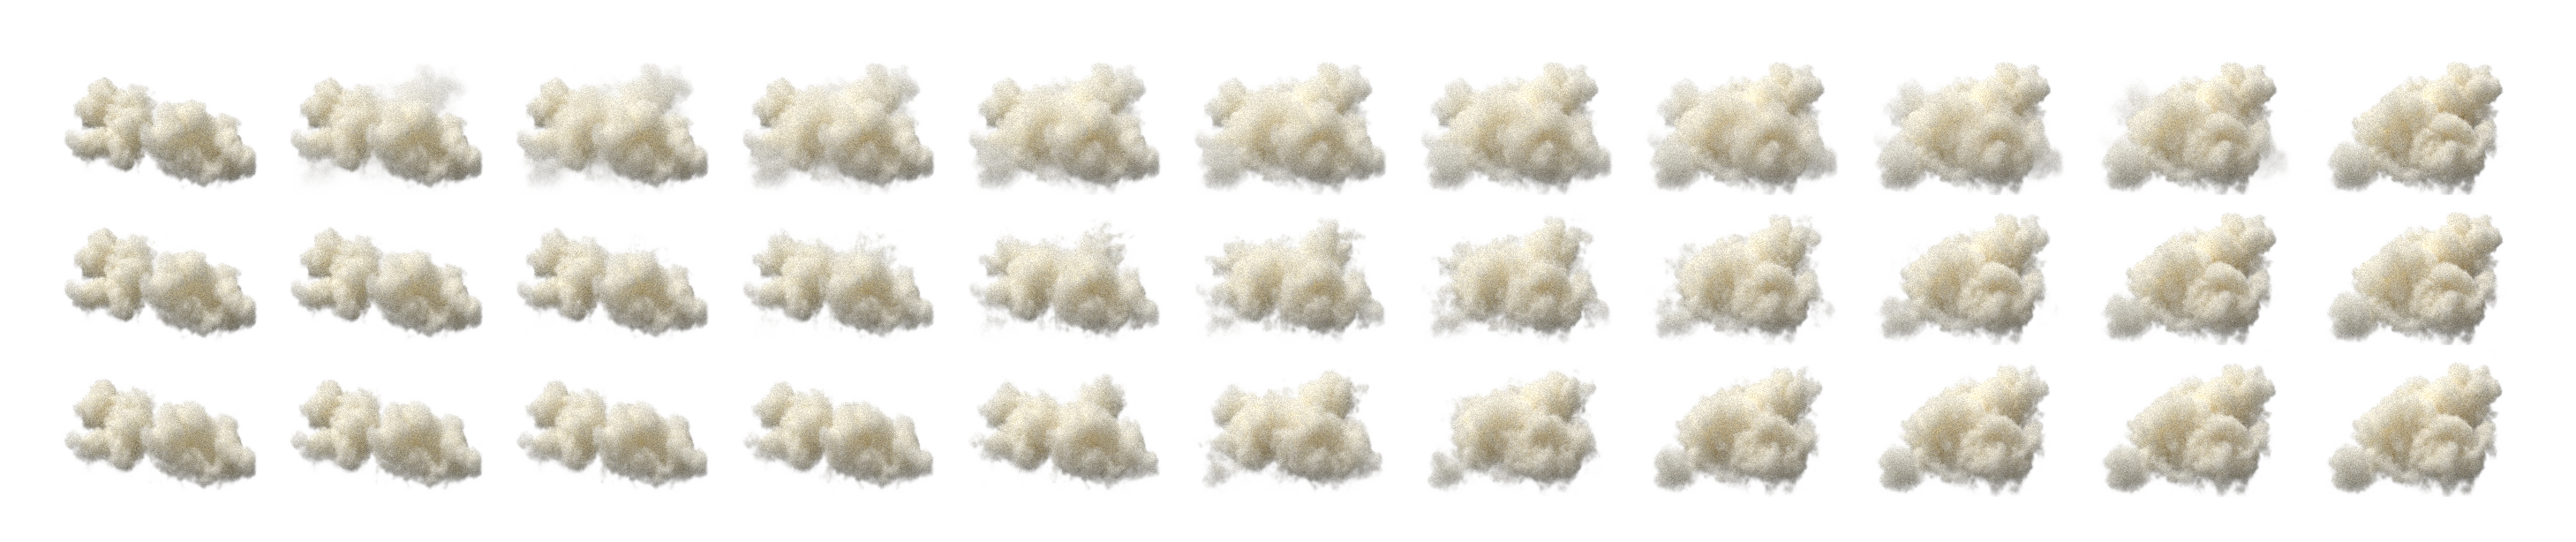

In [8]:
recorder = pipeline.create_recorder()
camera_position = (1.7, 1.4, 1.0)
SPP = 64
N = 10
for i in range(N + 1):
    alpha = i / N
    grid_gi = volume_interpolation_grid(ref_grid_a, ref_grid_b, alpha)
    grid_li = volume_interpolation_latent(ref_latent_a, ref_latent_b, alpha)
    grid_di = volume_interpolation_dps(ref_latent_a, ref_latent_b, alpha)
    recorder.new_keyframe(
        recorder.add_capture_image(
            cloudy.gamma_correction(
                recorder.render_image(grid_gi, width=256, height=512, samples=SPP,
                                  camera_position=camera_position
                                  ))
        ),
        recorder.add_capture_image(
            cloudy.gamma_correction(
                recorder.render_image(grid_li, width=256, height=512, samples=SPP,
                                  camera_position=camera_position
                                  ))
        ),
        recorder.add_capture_image(
            cloudy.gamma_correction(
                recorder.render_image(grid_di, width=256, height=512, samples=SPP,
                                  camera_position=camera_position
                                  ))
        )
    )

recorder.show_clip(recorder.num_frames, width=256, height=512)